# Image Super Resolution using Deep Learning

Author: Dominik Chodounský, Faculty of Information Technology, CTU in Prague

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, mean_squared_error
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras import callbacks
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, HTML, display
import cv2
import pandas as pd
import imageio as iio
from tqdm import tqdm
import os
import random
import warnings

warnings.filterwarnings("ignore")

In [2]:
from utils import *
from unet import *
from srgan import *

## Data setup

In [3]:
img_size = 64
target_size = 128
batch_size = 4
rand_seed = 42
train_dir = os.path.join('../', 'data', 'vimeo', 'train_paths.txt')
test_dir = os.path.join('../', 'data', 'vimeo', 'test_paths.txt')
save_dir = os.path.join('../', 'models')

np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)
random.seed(rand_seed)
os.environ['PYTHONHASHSEED'] = str(rand_seed)

warnings.filterwarnings("ignore")

In [4]:
train_list = []
with open(train_dir, 'r') as f:
    for line in f.readlines():
        train_list.append(line)
        
test_list = []
with open(test_dir, 'r') as f:
    for line in f.readlines():
        test_list.append(line)

In [5]:
print('Training:', len(train_list), 'septuplet sequences  |  Test images:', len(test_list), 'septuplet seqeunces')

Training: 7041 septuplet sequences  |  Test images: 783 septuplet seqeunces


In [ ]:
from tensorflow.keras.applications import VGG19

# Perceptual loss function 

# load pre-trained (imagenet) vgg network, excluding fully-connected layer on the top
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None,None,3))
vgg_layer = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

# make the net not trainable
for layer in vgg_layer.layers: 
    layer.trainable = False 

print(vgg_layer.summary())

def perceptual_loss(y_true,y_pred):
    '''This function computes the perceptual loss using an already trained VGG layer'''
    y_t=vgg_layer(y_true)
    y_p=vgg_layer(y_pred)
    loss=K.losses.mean_squared_error(y_t,y_p)
    return loss

## SR-U-Net

In [6]:
unet = unet(img_size)
unet.summary()

Model: "SR-U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

### Training

In [7]:
model_save = os.path.join(save_dir, 'vimeo_SRUNET_64_to_128' + '.h5')

# callback for early stopping regularization
early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# callback for continuous checkpointing of best model configuration
checkpointing = callbacks.ModelCheckpoint(
    filepath=model_save,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [8]:
train_gen = generator_vimeo(train_list, img_size, target_size, batch_size)

In [46]:
unet.compile(optimizer=Adam(learning_rate=0.001),
              #loss=psnr_loss,
              loss=MeanSquaredError(),
              metrics=[MeanSquaredError()])

history = unet.fit(x=train_gen,
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=30,
                    verbose=1,
                    callbacks=[early_stopping, checkpointing])

Epoch 1/30
1761/1761 [==============================] - ETA: 0s - loss: 0.0232 - psnr: 18.0986 - ssim: 0.6199 - mean_squared_error: 0.0232
Epoch 00001: loss improved from inf to 0.02316, saving model to ../models\vimeo_SRUNET_64_to_128.h5
1761/1761 [==============================] - 380s 216ms/step - loss: 0.0232 - psnr: 18.0986 - ssim: 0.6199 - mean_squared_error: 0.0232
Epoch 2/30
1761/1761 [==============================] - ETA: 0s - loss: 0.0140 - psnr: 19.9673 - ssim: 0.7260 - mean_squared_error: 0.0140
Epoch 00002: loss improved from 0.02316 to 0.01397, saving model to ../models\vimeo_SRUNET_64_to_128.h5
1761/1761 [==============================] - 382s 217ms/step - loss: 0.0140 - psnr: 19.9673 - ssim: 0.7260 - mean_squared_error: 0.0140
Epoch 3/30
1761/1761 [==============================] - ETA: 0s - loss: 0.0127 - psnr: 20.5138 - ssim: 0.7504 - mean_squared_error: 0.0127
Epoch 00003: loss improved from 0.01397 to 0.01271, saving model to ../models\vimeo_SRUNET_64_to_128.h5
176

### Image evaluation

In [9]:
unet = tf.keras.models.load_model(os.path.join(save_dir, 'vimeo_SRUNET_64_to_128.h5'), compile=False)

In [10]:
test_gen = generator_vimeo(test_list, img_size, target_size, batch_size)

In [12]:
get_stats(unet, test_gen, test_list)

100%|████████████████████████████████████████████████████████████████████████████████| 783/783 [05:45<00:00,  2.26it/s]


MSE: 0.0021393818
PSNR: 27.923904
SSIM: 0.8996611


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


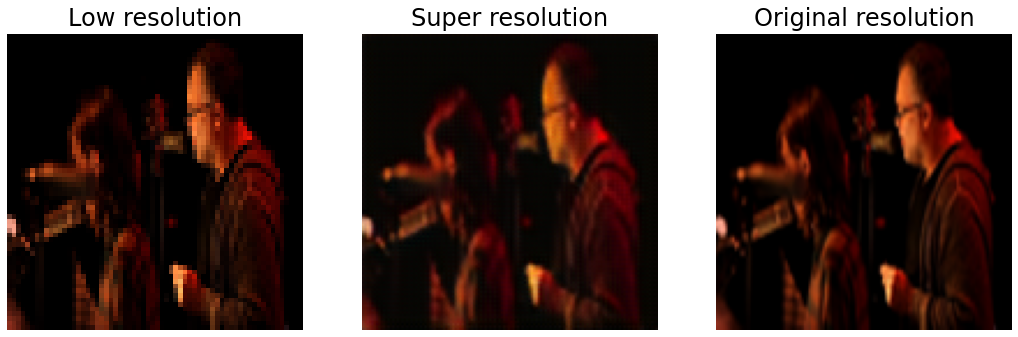

In [13]:
plot_comparison(unet, test_gen)

### Video evaluation

In [14]:
vid_name, ext = 'street', 'mp4'
reader = iio.get_reader('../data/' + vid_name + '.' + ext)
hr_frames = []
lr_frames = []
frames=[]
for i, im in enumerate(reader):
    hr_img = np.array(cv2.resize(im, (target_size, target_size), interpolation=cv2.INTER_CUBIC), dtype=np.uint8)
    hr_frames.append(np.array(hr_img, np.float32)/255.)
    
    lr_img = np.array(cv2.resize(im, (img_size, img_size), interpolation=cv2.INTER_CUBIC), dtype=np.uint8)
    lr_frames.append(np.array(lr_img, np.float32)/255.)

In [15]:
get_video_stats(unet, lr_frames, hr_frames)

304it [00:18, 16.56it/s]

MSE: 0.021373864
PSNR: 16.91301
SSIM: 0.51772875


In [16]:
sr_frames = []
for lr in lr_frames:
    sr = unet.predict(np.expand_dims(lr, axis=0))
    sr_frames.append(sr)
sr_frames = np.squeeze(np.array(sr_frames))

In [17]:
%%capture
iio.mimsave('../data/lr_' + vid_name + '.gif', lr_frames, fps=24)
iio.mimsave('../data/sr_' + vid_name + '.gif', sr_frames, fps=24)
iio.mimsave('../data/hr_' + vid_name + '.gif', hr_frames, fps=24)

In [18]:
plot_video_comparison('../data/lr_' + vid_name + '.gif', '../data/sr_' + vid_name + '.gif', '../data/hr_' + vid_name + '.gif')

,,


## SR-GAN

### Training

In [25]:
train_gan(img_size=img_size, target_size=target_size, epochs=10, batch_size=batch_size, batch_cnt=int(len(train_list) / batch_size),
          train_gen=generator_vimeo(train_list, img_size, target_size, 1), save_dir=save_dir)

--------------- Epoch 1 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1564/1564 [20:32<00:00,  1.27it/s]


discriminator_loss : 1.413010
gan_loss : [0.004273083060979843, 0.003815731033682823, 0.45735201239585876]
--------------- Epoch 2 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1564/1564 [20:56<00:00,  1.24it/s]


discriminator_loss : 0.381554
gan_loss : [0.0032326008658856153, 0.0029419048223644495, 0.2906963527202606]
--------------- Epoch 3 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1564/1564 [19:09<00:00,  1.36it/s]


discriminator_loss : 0.475016
gan_loss : [0.002316370140761137, 0.0019191382452845573, 0.3972319960594177]
--------------- Epoch 4 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1564/1564 [19:21<00:00,  1.35it/s]


discriminator_loss : 0.250882
gan_loss : [0.0025886509101837873, 0.002032365882769227, 0.55628502368927]
--------------- Epoch 5 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1564/1564 [19:10<00:00,  1.36it/s]


discriminator_loss : 0.364024
gan_loss : [0.0012817882234230638, 0.0008033437770791352, 0.4784444272518158]
--------------- Epoch 6 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1564/1564 [19:04<00:00,  1.37it/s]


discriminator_loss : 0.324155
gan_loss : [0.0020115801598876715, 0.0009971994441002607, 1.014380693435669]
--------------- Epoch 7 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1564/1564 [18:55<00:00,  1.38it/s]


discriminator_loss : 0.372128
gan_loss : [0.0016152597963809967, 0.001088700839318335, 0.5265589952468872]
--------------- Epoch 8 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1564/1564 [19:02<00:00,  1.37it/s]


discriminator_loss : 0.331392
gan_loss : [0.002365041058510542, 0.001610124483704567, 0.7549164891242981]
--------------- Epoch 9 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1564/1564 [19:16<00:00,  1.35it/s]


discriminator_loss : 0.395102
gan_loss : [0.0017702060285955667, 0.0011219345033168793, 0.6482714414596558]
--------------- Epoch 10 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1564/1564 [19:41<00:00,  1.32it/s]


discriminator_loss : 0.294636
gan_loss : [0.0025768144987523556, 0.0020847413688898087, 0.4920729696750641]


### Evaluation

In [19]:
G = tf.keras.models.load_model(os.path.join(save_dir, './gan_vimeo/catdogs_G_64_to_128__10.h5'))
G.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 64, 64, 64)   15616       input_4[0][0]                    
__________________________________________________________________________________________________
p_re_lu_17 (PReLU)              (None, 64, 64, 64)   64          conv2d_44[0][0]                  
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 64, 64, 64)   36928       p_re_lu_17[0][0]                 
_______________________________________________________________________________________

In [20]:
test_gen = generator_vimeo(test_list, img_size, target_size, batch_size)
get_stats(G, test_gen, test_list)

100%|████████████████████████████████████████████████████████████████████████████████| 783/783 [05:39<00:00,  2.31it/s]


MSE: 0.0050197174
PSNR: 29.96834
SSIM: 0.9163146


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


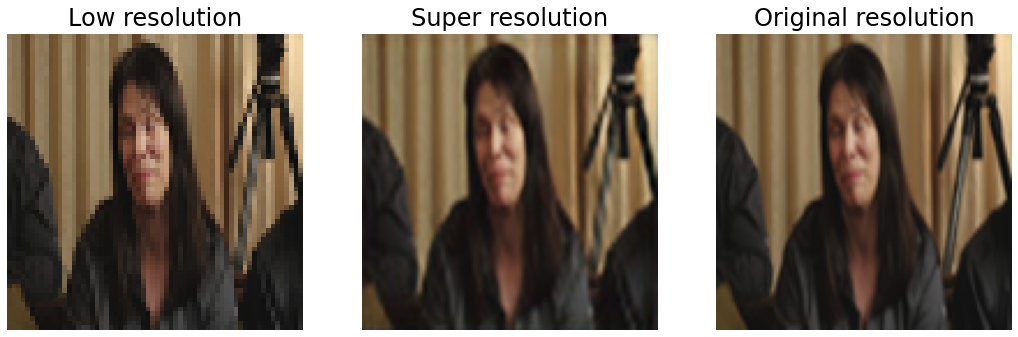

In [21]:
plot_comparison(G, test_gen)

In [22]:
get_video_stats(G, lr_frames, hr_frames)

304it [00:17, 16.99it/s]

MSE: 0.027356198
PSNR: 15.926112
SSIM: 0.5150625


In [23]:
sr_frames = []
for lr in lr_frames:
    hr = G.predict(np.expand_dims(lr, axis=0))
    sr_frames.append(hr)
sr_frames = np.squeeze(np.array(sr_frames))

In [24]:
iio.mimsave('../data/lr_' + vid_name + '.gif', np.uint8(lr_frames), fps=24)
iio.mimsave('../data/sr_' + vid_name + '.gif', np.uint8(sr_frames), fps=24)
iio.mimsave('../data/hr_' + vid_name + '.gif', np.uint8(hr_frames), fps=24)

In [25]:
plot_video_comparison('../data/lr_' + vid_name + '.gif', '../data/sr_' + vid_name + '.gif', '../data/hr_' + vid_name + '.gif')

,,
